In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Loading Data

In [2]:
df = pd.read_csv('car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


# Checking for Null Values

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

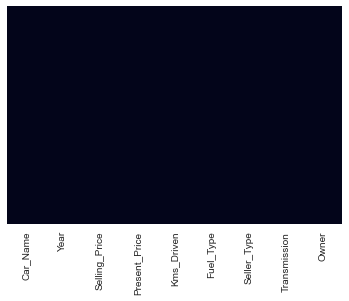

In [3]:
sns.set_style('darkgrid')
sns.heatmap(df.isnull(),cbar=False,yticklabels=False)
df.isnull().sum()

**No Null Values in our data!**

# Feature Analysis

### **1. Car Name**                                       
    Clearly Unique Car Names won't help our Model and also won't be feasible.
    But Car Company's reputation plays a big role in deciding resale value for a car
    so we try to extract out Company's Name from 'Car_Name'.  

In [4]:
Car_detail = df.Car_Name.unique()
Cars = pd.Series([i.split()[0] for i in Car_detail]).unique()
Cars

array(['ritz', 'sx4', 'ciaz', 'wagon', 'swift', 'vitara', 's', 'alto',
       'ertiga', 'dzire', 'ignis', '800', 'baleno', 'omni', 'fortuner',
       'innova', 'corolla', 'etios', 'camry', 'land', 'Royal', 'UM',
       'KTM', 'Bajaj', 'Hyosung', 'Mahindra', 'Honda', 'Yamaha', 'TVS',
       'Hero', 'Activa', 'Suzuki', 'i20', 'grand', 'i10', 'eon', 'xcent',
       'elantra', 'creta', 'verna', 'city', 'brio', 'amaze', 'jazz'],
      dtype=object)

In [5]:
MS_cars = Cars[:14]
Toyota_cars = Cars[14:19]
Honda = ['Activa']
Hyundai_cars = Cars[32:]

In [6]:
df['Car_Company'] = df['Car_Name'].apply(lambda x:x.split()[0])
df.Car_Company.replace(MS_cars,'Maruti Suzuki',inplace=True)
df.Car_Company.replace(Toyota_cars,'Toyota',inplace=True)
df.Car_Company.replace(Honda,'Honda',inplace=True)
df.Car_Company.replace(Hyundai_cars,'Hyundai',inplace=True)
df.Car_Company.replace(['land','Royal'],['Land Rover','Royal Enfield'],inplace=True)
df.Car_Company.unique()

array(['Maruti Suzuki', 'Toyota', 'Land Rover', 'Royal Enfield', 'UM',
       'KTM', 'Bajaj', 'Hyosung', 'Mahindra', 'Honda', 'Yamaha', 'TVS',
       'Hero', 'Suzuki', 'Hyundai'], dtype=object)

**We can Judge importance of our Features using Percent resale for each car
Where Percent resale is percent of original price at which it is being sold.**

In [7]:
df['Percent_resale'] = ( df['Selling_Price'] / df['Present_Price'] )*100

Car_Company
Bajaj            58.619737
Hero             59.116273
Honda            60.218529
Hyosung          39.130435
Hyundai          68.653446
KTM              66.247763
Land Rover       37.796976
Mahindra         82.142857
Maruti Suzuki    63.783082
Royal Enfield    73.859941
Suzuki           43.103448
TVS              66.109657
Toyota           52.775760
UM               93.406593
Yamaha           69.350963
Name: Percent_resale, dtype: float64

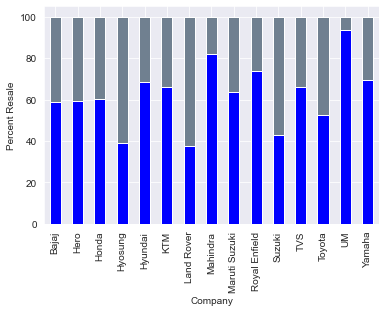

In [8]:
Company_analysis = df.groupby('Car_Company')['Percent_resale'].mean()
Company_analysis = pd.concat([Company_analysis,100-Company_analysis],axis=1)
Company_analysis.plot.bar(stacked=True,legend=False,color=['Blue','Slategrey'])
plt.ylabel('Percent Resale')
plt.xlabel('Company')
Company_analysis.iloc[:,0]

**Clearly we can see there is a difference in average percent resale for each company, 
For eg: we can see evident difference between percent resale of cars of Land Rover and Maruti Suzuki!**

### 2. Years
           Its logical that the older the car will be , cheaper it would sell
           So we will use 'Years_Old' feature rather than the feature 'Year' which tells in which year the car was
           bought.(We will use 2021 as our present year)

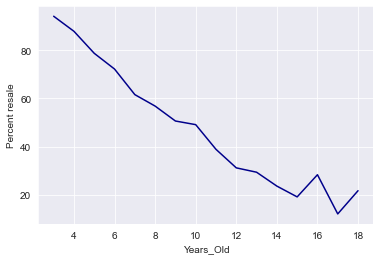

In [9]:
df['Years_Old'] = df['Year'].apply(lambda x:2021-x)
df.groupby('Years_Old').Percent_resale.mean().plot(kind = 'line',color='darkblue')
plt.ylabel('Percent resale');

**We can see that the data corresponds to our assumption**

### 3.Kms Driven
        Kms_Driven is the value of how much the car has been driven since when it was purchased

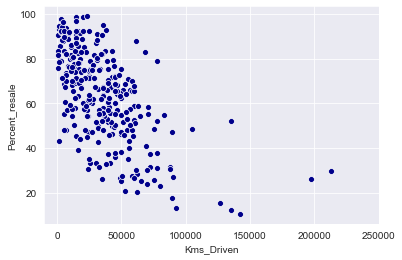

In [10]:
sns.scatterplot(df['Kms_Driven'],df['Percent_resale'],color='darkblue');
plt.xlim([-10000,250000]);

**It is clearly evident that the selling price drops as the total Km driven by the car increases**

### 4.Fuel type
     Diesel cars should sell better over petrol cars as they have better mileage but the contrary fact is 
     that they are hard to maintain hence that should decrease their value. Let's see what our data tells us about that.

Fuel_Type
CNG       50.982191
Diesel    67.964541
Petrol    62.414885
Name: Percent_resale, dtype: float64

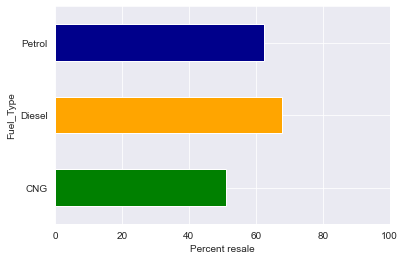

In [11]:
df.groupby('Fuel_Type').Percent_resale.mean().plot(kind='barh',color = ['green','orange','darkblue'])
plt.xlim([0,100])
plt.xlabel('Percent resale');
df.groupby('Fuel_Type').Percent_resale.mean()

**Diesel performs slightly better than petrol but the difference is not very significant, while CNG lags behind significantly**

### 5.Seller Type
     It gives us information whether it's being sold by a dealer or an individual

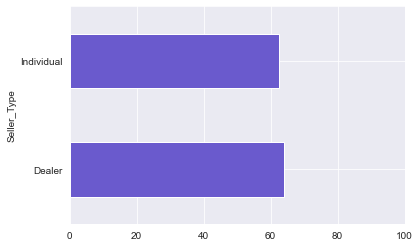

In [12]:
df.groupby('Seller_Type').Percent_resale.mean().plot(kind='barh',color='slateblue')
plt.xlim([0,100]);

**We can't see any significant difference between both the categories**

### 6.Transmission
     Whether the car had manual transmission or automatic transmission

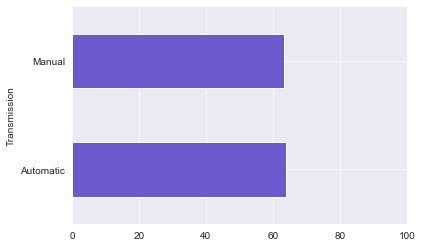

In [13]:
df.groupby('Transmission').Percent_resale.mean().plot(kind='barh',color='slateblue')
plt.xlim([0,100]);

**Here as well no significant difference between both categories**

### 7. Owner
     Whether it is being sold by first owner or second/third , logically if the car is not from first owner 
     it should deacrease its value

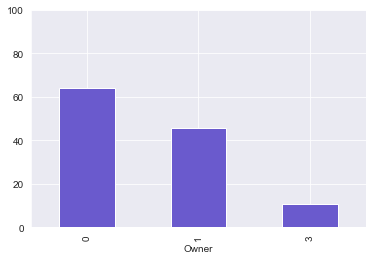

In [14]:
df.groupby('Owner').Percent_resale.mean().plot(kind='bar',color='slateblue')
plt.ylim([0,100]);

**As we can see car value decreases as no. of owner increases**

# Preparing our Model

Dropping required columns from our data

In [15]:
df.drop(['Car_Name','Year','Percent_resale'],axis=1,inplace=True)

**Getting dummy values for Categorical Data**

In [16]:
num_cols = df._get_numeric_data().columns
cat_cols = list(set(df.columns) - set(num_cols))
for col in cat_cols:
    cat = pd.get_dummies(df[col],drop_first=True)
    df = pd.concat([df,cat],axis=1)
    df.drop(col,axis=1,inplace=True)
print(df.shape)
df.head()

(301, 23)


,Selling_Price,Present_Price,Kms_Driven,Owner,Years_Old,Manual,Hero,Honda,Hyosung,Hyundai,...,Maruti Suzuki,Royal Enfield,Suzuki,TVS,Toyota,UM,Yamaha,Diesel,Petrol,Individual
0,3.35,5.59,27000,0,7,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,4.75,9.54,43000,0,8,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,7.25,9.85,6900,0,4,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,2.85,4.15,5200,0,10,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,4.60,6.87,42450,0,7,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


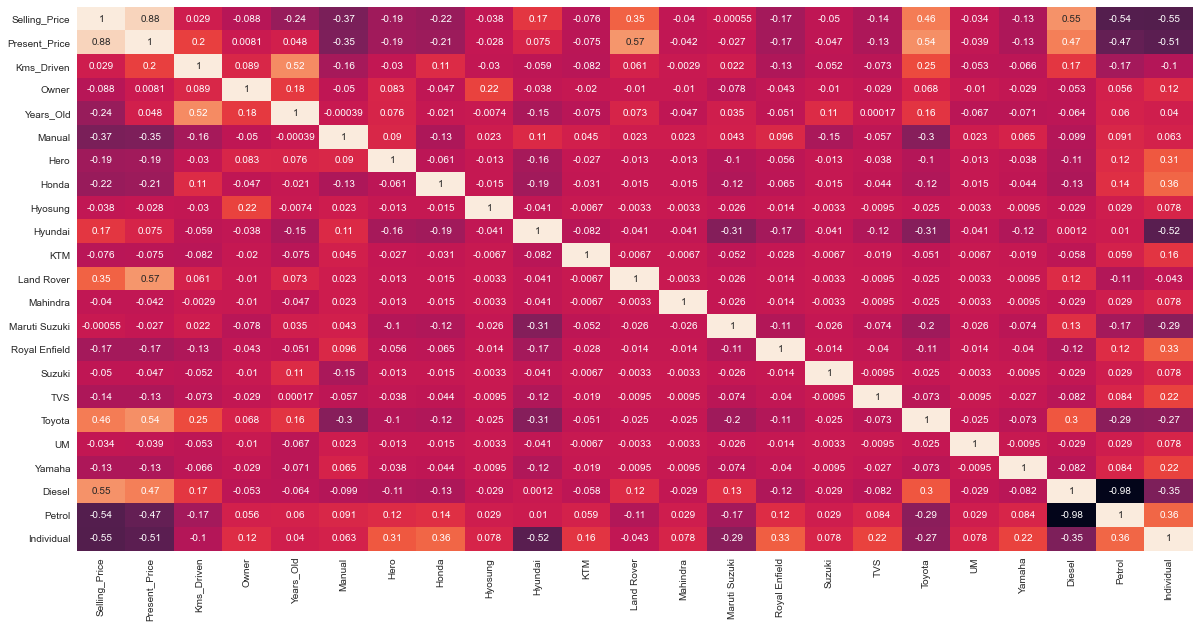

In [17]:
ax = plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cbar=False)

Diesel and Petrol feature are highly negatively correlated, it makes sense as we do not have a lot of CNG cars in our data, so if a car is not a diesel car, there is a high probability that the car will be petrol. This may cause the problem of Multi Collinearity and decrease our model's performance, but as we are using Random Forest Regressor multicollinearity won't be an issue with our model.

**Splitting data into train data and validation data**

In [18]:
X = df.drop(['Selling_Price'],axis=1)
y = df['Selling_Price']
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=22)

## Checking Impportance of Each Feature

In [19]:
test_model = ExtraTreesRegressor()
test_model.fit(x_train,y_train)
feat_imp = dict(zip(x_train.columns,test_model.feature_importances_))
test_pred = test_model.predict(x_test)
print(mean_squared_error(y_test,test_pred)**0.5)
print(r2_score(y_test,test_pred))
feat_imp

1.48355460004392
0.8378653376022562


{'Present_Price': 0.37621944898669785,
 'Kms_Driven': 0.029470354425501822,
 'Owner': 0.0002427765667393595,
 'Years_Old': 0.05697934824251022,
 'Manual': 0.14568419232091354,
 'Hero': 3.469013588869782e-06,
 'Honda': 3.34087146842697e-05,
 'Hyosung': 3.0663104457869574e-05,
 'Hyundai': 0.0037167565935567826,
 'KTM': 0.00016200878662158758,
 'Land Rover': 0.030912869040260034,
 'Mahindra': 1.2004875847789803e-05,
 'Maruti Suzuki': 0.0026921732403829193,
 'Royal Enfield': 0.00042638552801318904,
 'Suzuki': 1.9047715780085274e-07,
 'TVS': 8.207697604844453e-06,
 'Toyota': 0.009329391413299063,
 'UM': 0.0,
 'Yamaha': 5.985478949156034e-06,
 'Diesel': 0.23254055644233668,
 'Petrol': 0.0036015735804517893,
 'Individual': 0.1079282354704246}

'UM' and 'Suzuki' has really less feature importance , it  might be because we don't have sufficient data for the specific category , so its better for our model to drop these features.

In [20]:
X = df.drop(['Selling_Price','UM','Suzuki'],axis=1)
y = df['Selling_Price']
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=22)
test_model.fit(x_train,y_train)
feat_imp = dict(zip(x_train.columns,test_model.feature_importances_))
test_pred = test_model.predict(x_test)
print(mean_squared_error(y_test,test_pred)**0.5)
print(r2_score(y_test,test_pred))
feat_imp

1.3355450780149052
0.868602862299073


{'Present_Price': 0.364671720730077,
 'Kms_Driven': 0.03155809133747969,
 'Owner': 0.00019929307515423217,
 'Years_Old': 0.05718363011823942,
 'Manual': 0.13816538476021265,
 'Hero': 3.882477102491209e-06,
 'Honda': 3.9835945461195866e-05,
 'Hyosung': 3.0270844716043824e-05,
 'Hyundai': 0.0033881656401392444,
 'KTM': 0.00014546825255209753,
 'Land Rover': 0.03995599845913921,
 'Mahindra': 1.0791095985474857e-05,
 'Maruti Suzuki': 0.0036004868417689735,
 'Royal Enfield': 0.0003960430807913404,
 'TVS': 7.463643604167795e-06,
 'Toyota': 0.009098385607531142,
 'Yamaha': 5.4994011187044174e-06,
 'Diesel': 0.23172939028816597,
 'Petrol': 0.003361939050117835,
 'Individual': 0.11644825935064328}

### Hyper Parameter Tuning
We are using Random Forest regressor for our model, and its important for our model to get the right parameters , hence we will use Randomizedsearch Cross Validation for the same

In [21]:
reg = RandomForestRegressor(bootstrap=True,oob_score=True)
prm_grid = dict(n_estimators = [100,200,300,400,500,600,700,800,900,1000],
               max_depth = [None , 4 , 7 , 10 , 12 , 15 , 20],
               min_samples_split = [2,5,8,10,12,15,20])
grid = RandomizedSearchCV(reg , prm_grid , n_iter = 5 ,scoring ='neg_root_mean_squared_error', cv=5 , verbose = 5)
grid.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=500, min_samples_split=10, max_depth=None ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_split=10, max_depth=None, score=-1.601, total=   1.7s
[CV] n_estimators=500, min_samples_split=10, max_depth=None ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, max_depth=None, score=-4.281, total=   1.6s
[CV] n_estimators=500, min_samples_split=10, max_depth=None ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, max_depth=None, score=-0.312, total=   1.5s
[CV] n_estimators=500, min_samples_split=10, max_depth=None ..........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, max_depth=None, score=-0.735, total=   1.5s
[CV] n_estimators=500, min_samples_split=10, max_depth=None ..........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, max_depth=None, score=-1.190, total=   1.4s
[CV] n_estimators=500, min_samples_split=8, max_depth=4 ..............
[CV]  n_estimators=500, min_samples_split=8, max_depth=4, score=-1.741, total=   1.4s
[CV] n_estimators=500, min_samples_split=8, max_depth=4 ..............
[CV]  n_estimators=500, min_samples_split=8, max_depth=4, score=-4.367, total=   1.5s
[CV] n_estimators=500, min_samples_split=8, max_depth=4 ..............
[CV]  n_estimators=500, min_samples_split=8, max_depth=4, score=-0.312, total=   1.4s
[CV] n_estimators=500, min_samples_split=8, max_depth=4 ..............
[CV]  n_estimators=500, min_samples_split=8, max_depth=4, score=-0.920, total=   1.4s
[CV] n_estimators=500, min_samples_split=8, max_depth=4 ..............
[CV]  n_estimators=500, min_samples_split=8, max_depth=4, score=-1.008, total=   1.5s
[CV] n_estimators=500, min_samples_split=20, max_depth=None ..........
[CV]  n_estimators=500, min_samples_split=20, max_dept

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   36.4s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=True),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 4, 7, 10, 12, 15,
                                                      20],
                                        'min_samples_split': [2, 5, 8, 10, 12,
                                                              15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='neg_root_mean_squared_error', verbose=5)

In [22]:
print(grid.best_score_)
print(grid.best_estimator_)
param = grid.best_params_
param

-1.6222628805823973
RandomForestRegressor(max_depth=20, min_samples_split=12, oob_score=True)


{'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 20}

In [23]:
reg =  RandomForestRegressor(**param , bootstrap=True,oob_score=True)
reg.fit(X,y)
reg.oob_score_

0.8738790245880991

In [24]:
reg.predict(np.array([6.5,33000,0,8,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(1,-1))

array([3.78217987])